<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP (Part 2 EDA)
#### Binary CLassification of Subreddit Posts

 - [Exploratory Data Analysis](#Exploratory-Data-Analysis)


## Exploratory Data Analysis

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import en_core_web_sm
#nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
# From Part 1, retriving genuine questions on the topic of relationship

genuine_qns_df = pd.read_csv('../datasets/genuine_qns.csv')

In [4]:
# Drop 'Unnamed: 0' column

genuine_qns_df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
#Map genuine questions column as 0 and spam/non-related enquiries as 1 since it's a binary classification problem

genuine_qns_df['subreddit'] = genuine_qns_df['subreddit'].map(lambda x: 0 if x == 'relationship_advice' else 1)

In [6]:
genuine_qns_df['subreddit'].value_counts(normalize=True)

0    1.0
Name: subreddit, dtype: float64

In [7]:
genuine_qns_df.head()

,subreddit,selftext,title
0,0,So i went to a party at my buddies house and e...,Into a girl my friends also into
1,0,NaN,Our relationship is awkward in life but not ov...
2,0,This girl and I have grown closer. It was all ...,"LDR with a girl an hour away. I'm 16, she's 17..."
3,0,So redditors here's the story. My gf is mad th...,My g[f18] is mad at [m20]e on NYE..does she ha...
4,0,My GF and I have been together a year and a ha...,Problems with her friends and my friends. No t...


In [8]:
# From Part 1, retriving unrelated questions

unrelated_qns_df = pd.read_csv('../datasets/unrelated_qns.csv')

In [9]:
# Drop 'Unnamed: 0' column

unrelated_qns_df.drop(columns='Unnamed: 0', inplace=True)

In [10]:
#Map genuine questions column as 0 and spam/non-related enquiries as 1 since it's a binary classification problem

unrelated_qns_df['subreddit'] = unrelated_qns_df['subreddit'].map(lambda x: 0 if x == 'relationship_advice' else 1)

In [11]:
unrelated_qns_df['subreddit'].value_counts(normalize=True)

1    1.0
Name: subreddit, dtype: float64

In [12]:
unrelated_qns_df.head()

,subreddit,selftext,title
0,1,"Looking for some art, thought there might be s...","Ok, weird question. Is there a subreddit to co..."
1,1,A truly stupid question. It's almost sad that ...,"If it's well over 98℉ outside, does passed gas..."
2,1,"Okay, stupid question, but does excel ever end...",Is Excel never ending?
3,1,According to the [CIA factbook](https://www.ci...,Why is Lybia's oil so important?
4,1,"Because, according to my middle school health ...",Can hemophiliacs get heart attacks?


In [13]:
# Combined both selftext and title as 1 column for easier analysis 
genuine_qns_df['text'] = genuine_qns_df['title'].fillna('') + ' ' + genuine_qns_df['selftext'].fillna('')
unrelated_qns_df['text'] = unrelated_qns_df['title'].fillna('') + ' ' + unrelated_qns_df['selftext'].fillna('')

#### Data Cleaning

In [14]:
# Checking for NANs 
print(genuine_qns_df.isnull().sum())
print(unrelated_qns_df.isnull().sum())

subreddit      0
selftext     118
title          0
text           0
dtype: int64
subreddit       0
selftext     3177
title           0
text            0
dtype: int64


#### Check for duplicate in the 8000 posts

In [15]:
#Check and drop duplicates
print(genuine_qns_df.shape)
print(genuine_qns_df['text'].nunique())
genuine_qns_df = genuine_qns_df.drop_duplicates(subset=['text'])
print(genuine_qns_df.shape)

(8000, 4)
7983
(7983, 4)


In [16]:
#Check and drop duplicates
print(unrelated_qns_df.shape)
print(unrelated_qns_df['text'].nunique())
unrelated_qns_df = unrelated_qns_df.drop_duplicates(subset=['text'])
print(unrelated_qns_df.shape)

(8000, 4)
7971
(7971, 4)


#### Creating a custom function to remove the following from each post:
- Remove deleted posts
- Remove URLs
- Remove punctuations
- Remove Non-ASCII characters
- Remove raw text of comments and submission self texts
- Remove stopwords

Reddit uses some characters in the raw text of comments and submission selftexts that may need to be removed if just the plain natural text is required for NLP/Data Science tasks. redditcleaner module cleans this text data.

In [17]:
!pip install redditcleaner
import redditcleaner

In [18]:
def clean_text(text):
    
    text = str(text.lower())
    
    #'[removed]' means it was removed by a mod or automoderator, or the spam filter
    if '[removed]' in text:
        text = ''
    else:
        pass
    
    #remove urls
    text = re.sub(r'http\S+', "", text)
    
    #remove punctuations
    text = re.sub("[^\w\s]", "", text)
    
    #remove non-ascii characters
    text = text.encode('ascii',errors='ignore').decode()
    
    #remove markdown character from raw text
    text = redditcleaner.clean(text)
    
    #remove stopwords from NLTK default library 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str(text))
    text = [w for w in word_tokens if not w.lower() in stop_words]
    text = ' '.join(text)
    
    return text

In [19]:
genuine_qns_df['cleaned_text'] = genuine_qns_df['text'].map(lambda x: clean_text(x))
unrelated_qns_df['cleaned_text'] = unrelated_qns_df['text'].map(lambda x: clean_text(x))

In [20]:
genuine_qns_df.head()

,subreddit,selftext,title,text,cleaned_text
0,0,So i went to a party at my buddies house and e...,Into a girl my friends also into,Into a girl my friends also into So i went to ...,girl friends also went party buddies house end...
1,0,NaN,Our relationship is awkward in life but not ov...,Our relationship is awkward in life but not ov...,relationship awkward life text message way mak...
2,0,This girl and I have grown closer. It was all ...,"LDR with a girl an hour away. I'm 16, she's 17...","LDR with a girl an hour away. I'm 16, she's 17...",ldr girl hour away im 16 shes 17 got together ...
3,0,So redditors here's the story. My gf is mad th...,My g[f18] is mad at [m20]e on NYE..does she ha...,My g[f18] is mad at [m20]e on NYE..does she ha...,gf18 mad m20e nyedoes reason redditors heres s...
4,0,My GF and I have been together a year and a ha...,Problems with her friends and my friends. No t...,Problems with her friends and my friends. No t...,problems friends friends time gf together year...


In [21]:
unrelated_qns_df.head()

,subreddit,selftext,title,text,cleaned_text
0,1,"Looking for some art, thought there might be s...","Ok, weird question. Is there a subreddit to co...","Ok, weird question. Is there a subreddit to co...",ok weird question subreddit connect redditors ...
1,1,A truly stupid question. It's almost sad that ...,"If it's well over 98℉ outside, does passed gas...","If it's well over 98℉ outside, does passed gas...",well 98 outside passed gas rise spreads truly ...
2,1,"Okay, stupid question, but does excel ever end...",Is Excel never ending?,"Is Excel never ending? Okay, stupid question, ...",excel never ending okay stupid question excel ...
3,1,According to the [CIA factbook](https://www.ci...,Why is Lybia's oil so important?,Why is Lybia's oil so important? According to ...,lybias oil important according cia factbook li...
4,1,"Because, according to my middle school health ...",Can hemophiliacs get heart attacks?,"Can hemophiliacs get heart attacks? Because, a...",hemophiliacs get heart attacks according middl...


#### Feature Engineering

Create 2 features, namely "word_count" and "length count" to visualize the distribution of post lengths and word counts

In [22]:
# Creating a new column to count the chars in 'cleaned_text' column 
genuine_qns_df['length_count'] = genuine_qns_df['cleaned_text'].map(lambda x: len(str(x)))
unrelated_qns_df['length_count'] = unrelated_qns_df['cleaned_text'].map(lambda x: len(str(x)))

In [91]:
# Creating a new column to count the number of words in 'cleaned_text' column 
genuine_qns_df['word_count'] = genuine_qns_df['cleaned_text'].map(lambda x: len(str(x).split()))
unrelated_qns_df['word_count'] = unrelated_qns_df['cleaned_text'].map(lambda x: len(str(x).split()))

In [92]:
# drop original selftext and title columns
genuine_qns_df.drop(columns=['selftext','title'],inplace=True)
unrelated_qns_df.drop(columns=['selftext','title'],inplace=True)

In [93]:
genuine_qns_df.head()

,subreddit,text,cleaned_text,length_count,word_count
0,0,Into a girl my friends also into So i went to ...,girl friends also went party buddies house end...,295,49
1,0,Our relationship is awkward in life but not ov...,relationship awkward life text message way mak...,62,9
2,0,"LDR with a girl an hour away. I'm 16, she's 17...",ldr girl hour away im 16 shes 17 got together ...,932,154
3,0,My g[f18] is mad at [m20]e on NYE..does she ha...,gf18 mad m20e nyedoes reason redditors heres s...,663,118
4,0,Problems with her friends and my friends. No t...,problems friends friends time gf together year...,1422,226


In [94]:
unrelated_qns_df.head()

,subreddit,text,cleaned_text,length_count,word_count
0,1,"Ok, weird question. Is there a subreddit to co...",ok weird question subreddit connect redditors ...,212,29
1,1,"If it's well over 98℉ outside, does passed gas...",well 98 outside passed gas rise spreads truly ...,108,18
2,1,"Is Excel never ending? Okay, stupid question, ...",excel never ending okay stupid question excel ...,109,17
3,1,Why is Lybia's oil so important? According to ...,lybias oil important according cia factbook li...,335,51
4,1,"Can hemophiliacs get heart attacks? Because, a...",hemophiliacs get heart attacks according middl...,174,24


#### Visualization the distribution of post lengths & word count

<AxesSubplot:title={'center':'Unrelated Question (Character Count)'}, xlabel='length_count', ylabel='Count'>

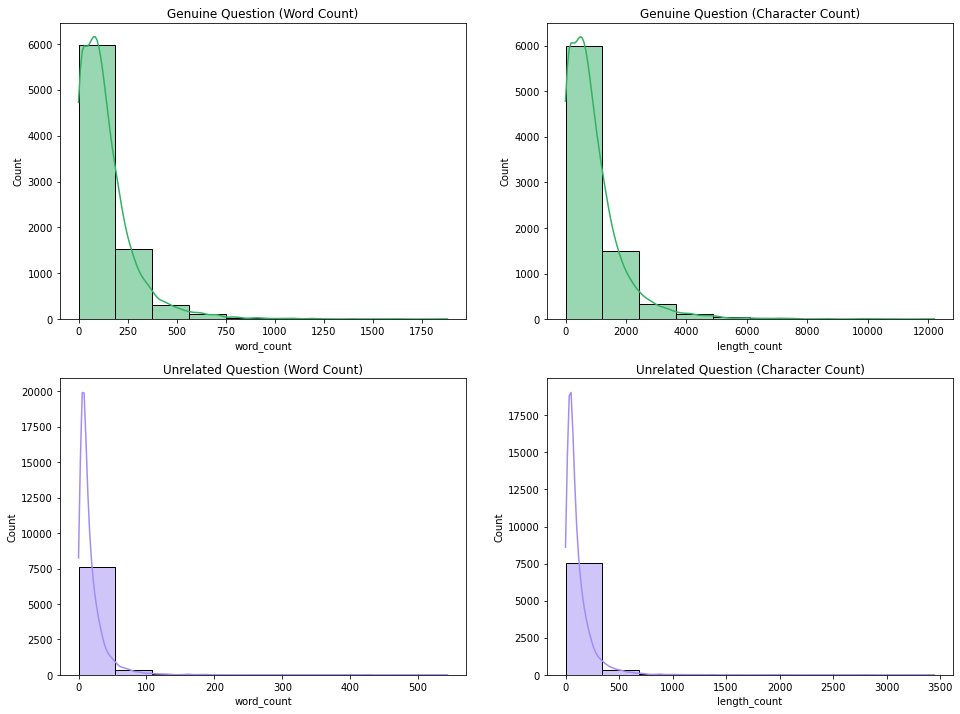

In [95]:
color1 = "#32b165"
color2 = "#a38cf4"
plt.figure(figsize = (16,12))

ax=plt.subplot(2, 2, 1)
ax.set_title('Genuine Question (Word Count)')
sns.histplot(genuine_qns_df['word_count'],bins=10,kde=True,color=color1)

ax=plt.subplot(2, 2, 2)
ax.set_title('Genuine Question (Character Count)')
sns.histplot(genuine_qns_df['length_count'],bins=10,kde=True,color=color1)

ax=plt.subplot(2, 2, 3)
ax.set_title('Unrelated Question (Word Count)')
sns.histplot(unrelated_qns_df['word_count'],bins=10,kde=True,color=color2)

ax=plt.subplot(2, 2, 4)
ax.set_title('Unrelated Question (Character Count)')
sns.histplot(unrelated_qns_df['length_count'],bins=10,kde=True,color=color2)


In [96]:
genuine_qns_df.describe()

,subreddit,length_count,word_count
count,7983.0,7983.000000,7983.000000
mean,0.0,919.196793,142.314042
std,0.0,967.337025,148.984424
min,0.0,0.000000,0.000000
25%,0.0,303.000000,47.000000
50%,0.0,684.000000,107.000000
75%,0.0,1220.000000,190.000000
max,0.0,12200.000000,1881.000000


In [97]:
unrelated_qns_df.describe()

,subreddit,length_count,word_count
count,7971.0,7971.000000,7971.000000
mean,1.0,115.716974,17.678961
std,0.0,155.170700,22.384295
min,1.0,0.000000,0.000000
25%,1.0,37.000000,6.000000
50%,1.0,69.000000,11.000000
75%,1.0,140.000000,22.000000
max,1.0,3446.000000,543.000000


- Observations:
    
    The distribution plots are right-skewed and show a fair amount of outliers, however we did not remove them as it may impact model performance.

In [98]:
#Dropping rows with empty cell under 'cleaned_text' column
genuine_qns_df = genuine_qns_df[genuine_qns_df['word_count']!=0]
unrelated_qns_df = unrelated_qns_df[unrelated_qns_df['word_count']!=0]

In [99]:
genuine_qns_df.shape

(7651, 5)

In [100]:
unrelated_qns_df.shape

(7900, 5)

## Explore most frequent words with Count Vectorization

In [101]:
#genuine_qns_df
cv = CountVectorizer(stop_words='english',ngram_range=(1,1))
cv.fit(genuine_qns_df['cleaned_text'])
cv_transformed = cv.transform(genuine_qns_df['cleaned_text'])
cv_df = pd.DataFrame(cv_transformed.todense(),columns=cv.get_feature_names())

In [102]:
genuine_most_common_words = cv_df.sum().sort_values(ascending=False)

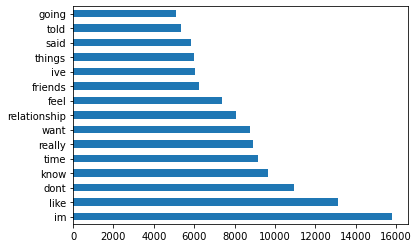

In [103]:
genuine_most_common_words.head(15).plot(kind='barh');

In [104]:
#unrelated_qns_df
cv = CountVectorizer(stop_words='english',ngram_range=(1,1))
cv.fit(unrelated_qns_df['cleaned_text'])
cv_transformed = cv.transform(unrelated_qns_df['cleaned_text'])
cv_df = pd.DataFrame(cv_transformed.todense(),columns=cv.get_feature_names())

In [105]:
unrelated_most_common_words = cv_df.sum().sort_values(ascending=False)

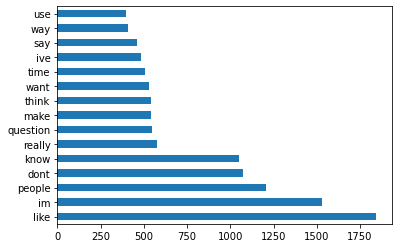

In [106]:
unrelated_most_common_words.head(15).plot(kind='barh');

## Explore most frequent words with TfidfVectorizer

In [107]:
#genuine_qns_df
tvec = TfidfVectorizer(stop_words='english',ngram_range=(1,1))
tvec.fit(genuine_qns_df['cleaned_text'])
tvec_transformed = tvec.transform(genuine_qns_df['cleaned_text'])
tvec_df = pd.DataFrame(tvec_transformed.todense(),columns=tvec.get_feature_names())

In [108]:
genuine_most_common_words_tfid = tvec_df.sum().sort_values(ascending=False)

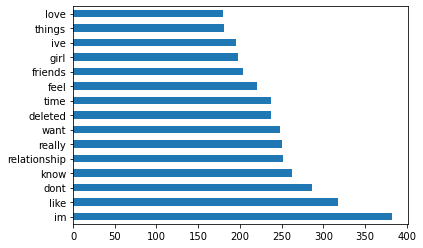

In [109]:
genuine_most_common_words_tfid.head(15).plot(kind='barh');

In [110]:
#unrelated_qns_df
tvec = TfidfVectorizer(stop_words='english',ngram_range=(1,1))
tvec.fit(unrelated_qns_df['cleaned_text'])
tvec_transformed = tvec.transform(unrelated_qns_df['cleaned_text'])
tvec_df = pd.DataFrame(tvec_transformed.todense(),columns=tvec.get_feature_names())

In [111]:
unrelated_most_common_words_tfid = tvec_df.sum().sort_values(ascending=False)

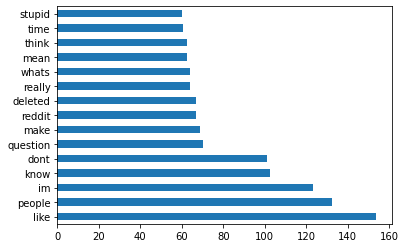

In [112]:
unrelated_most_common_words_tfid.head(15).plot(kind='barh');

- Observations:
    
    Although the top 15 terms for each topic are mainly similar in both Count Vectorizer and TFID techniques, words like 'im' and'really' appear often in both subreddits, potentially lowering the performance of our model. As a result, hyperparameter tuning of parameters (ngram range, max features, max df, min df, and so on) is required at a later stage.

In [113]:
#savings the cleaned data to csv
genuine_qns_df.to_csv('../datasets/cleaned_genuine_qns.csv')
unrelated_qns_df.to_csv('../datasets/cleaned_unrelated_qns.csv')

## Continue in Project3-Part3